#Install Requirements

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import zipfile
import os


In [ ]:
pip install Cmake

#Download Kaggle dataset

In [ ]:
pip install -U kaggle-cli

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 59.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 17.0 MB/s eta 0:00:00
  Created wheel for kaggle-cli: filename=kaggle_cli-0.12.13-py3-none-any.whl size=9468 sha256=408e970b2a44bd7a9734c71da861c1bc2ec92302595efc3802ca58906562513a
  Stored in directory: /root/.cache/pip/wheels/76/71/79/84b4614152023629f0019a6632e4dd14c4455d717114d7d6f7
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See

In [ ]:
cd

/root


In [ ]:
cd ..

/


In [ ]:
cd content

/content


In [ ]:
cp /content/kaggle.json /root/.kaggle/

In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

100% 712M/714M [00:42<00:00, 18.7MB/s]
100% 714M/714M [00:42<00:00, 17.6MB/s]


#Dataset Preprocessing

In [ ]:
#unzipping the files
try:
  with zipfile.ZipFile('/content/lgg-mri-segmentation.zip') as z:
    z.extractall()
    print('Done')
except:
  FileNotFoundError()

Done


In [ ]:
#images and masks are readed separately and appended to list.
path='/content/lgg-mri-segmentation/kaggle_3m'
images=[]
masks=[]
fig=plt.figure()
for filename in os.listdir(path):
  f= os.path.join(path, filename)
  if os.path.isdir(f):
    iters = int(len(os.listdir(f))/2)
    for i in range(1, iters):
      image= os.path.join(f, filename )+'_'+str(i)+'.tif'
      mask= os.path.join(f, filename )+'_'+str(i)+'_mask.tif'
      image=cv2.imread(image, cv2.COLOR_BGR2RGB)
      mask = cv2.imread(mask, cv2.COLOR_BGR2RGB)
      images.append(image)
      masks.append(mask)

#converting lists to numpy array
image_array=np.array(images)
mask_array=np.array(masks)


<Figure size 640x480 with 0 Axes>

In [ ]:
class preprocess():
  def __init__(self, image, mask):
    self.image=image
    self.mask=mask

  def preprocess_image(self):
    """
    Resizing all images and normalizing
    """
    new_image=[]
    for i in range(len(self.image)):
      image_sz= cv2.resize(self.image[i], (128, 128))
      image_sz= image_sz/255.0
      image_sz=image_sz.astype(np.float32)
      new_image.append(image_sz)
    return new_image

  def preprocess_mask(self):
    """
    Resizing all masks and normalizing
    """
    new_mask=[]
    for i in range(len(self.mask)):
      mask_sz= cv2.resize(self.mask[i], (128, 128))
      mask_sz= mask_sz/255.0
      mask_sz=mask_sz.astype(np.float32)
      mask_sz = np.expand_dims(mask_sz, axis=-1)
      new_mask.append(mask_sz)
    return new_mask


In [ ]:
process=preprocess(image_array, mask_array)
last_images= process.preprocess_image()
last_mask= process.preprocess_mask()

In [ ]:
#preprocessed images and masks list are converted to numpy array
image_array=np.array(last_images)
mask_array=np.array(last_mask)

BATCH_SIZE=64
BUFFER_SIZE=1000

#separation of images and masks to train and test datasets and then, conversion to tensors
train_image, test_image, train_mask, test_mask= train_test_split(image_array, mask_array,test_size=0.2, random_state=42 )
train_image, val_image, train_mask, val_mask= train_test_split(train_image, train_mask,test_size=0.25, random_state=42 )
train_dataset = tf.data.Dataset.from_tensor_slices((train_image, train_mask))
validation_dataset = tf.data.Dataset.from_tensor_slices((val_image, val_mask))
test_dataset=tf.data.Dataset.from_tensor_slices((test_image, test_mask))

#shuffling and batching the train and test dataset
train_dataset=train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test_dataset=test_dataset.batch(BATCH_SIZE)

#Visualization of dataset

In [ ]:
#visualization of images with masks
def visualize(len_of_image):
  plt.figure(figsize=(20,20))
  for i in range (1, len_of_image,2):
    plt.subplot(1,len_of_image, i)
    plt.imshow(train_image[i])
    plt.subplot(1,len_of_image, i+1)
    plt.imshow(np.squeeze(train_mask[i]))

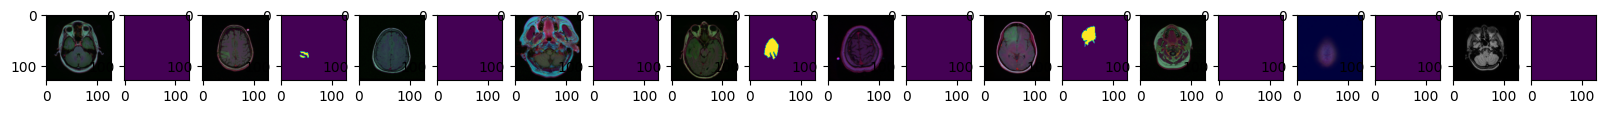

In [ ]:
visualize(20)

#U-NET model structure

In [ ]:
def conv2d (input_tensor, n_filters, kernel_size=3):

  x= input_tensor
  for i in range(2):
    x= tf.keras.layers.Conv2D(filters= n_filters, kernel_size= (kernel_size, kernel_size),
                              kernel_initializer='he_normal', padding='same')(x)
    x=tf.keras.layers.Activation('relu')(x)
  return x


def encoder_block(inputs, n_filters = 64, pool_size=(2, 2), dropout=0.3):

  f= conv2d(inputs, n_filters=n_filters)
  p= tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
  p= tf.keras.layers.Dropout(dropout)(p)

  return f, p

def encoder(inputs):

  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2, 2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters = 128, pool_size=(2, 2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters = 256, pool_size=(2, 2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters = 512, pool_size=(2, 2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

def bottleneck(inputs):
  bottle_neck= conv2d(inputs, n_filters= 1024)
  return bottle_neck

def decoder_block(inputs, conv_output, kernel_size, strides, n_filters, droupout=0.3):

  u = tf.keras.layers.Conv2DTranspose(filters= n_filters, strides = strides, kernel_size=kernel_size, padding='same')(inputs)
  s= tf.keras.layers.concatenate([u, conv_output])
  s= tf.keras.layers.Dropout(droupout)(s)
  s= conv2d(s, kernel_size=3, n_filters= n_filters)

  return s

def decoder(inputs, conv_output, output_channels):

  f1,f2, f3,  f4= conv_output
  s6 = decoder_block(inputs, f4, n_filters= 512, strides= (2, 2), kernel_size=(3,3), droupout=0.3)
  s7 = decoder_block(s6, f3, n_filters= 256, strides= (2, 2), kernel_size=(3,3), droupout=0.3)
  s8 = decoder_block(s7, f2, n_filters= 128, strides= (2, 2), kernel_size=(3,3), droupout=0.3)
  s9 = decoder_block(s8, f1, n_filters= 64, strides= (2, 2), kernel_size=(3,3), droupout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1,1), activation ='softmax')(s9)


  return outputs



In [ ]:
OUTPUT_CHANNELS=2
def unet():

  inputs= tf.keras.layers.Input(shape=(128, 128, 3,))
  encoder_output, convs= encoder(inputs)

  bottle_output= bottleneck(encoder_output)
  output= decoder(inputs=bottle_output, conv_output=convs, output_channels=OUTPUT_CHANNELS )

  model= tf.keras.Model(inputs=inputs, outputs = output)
  return model

model= unet()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['activation[0][0]']          
                                                                                              

#Training the model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
TRAIN_LENGTH = len(train_image)
BATCH_SIZE=64
STEPS_PER_EPOCH= TRAIN_LENGTH//BATCH_SIZE
model_history=model.fit(train_image, train_mask,validation_data=(val_image, val_mask), epochs=30)

Epoch 1/30
72/72 [==============================] - 83s 740ms/step - loss: 1.9127 - accuracy: 0.9862 - val_loss: 0.0923 - val_accuracy: 0.9889
Epoch 2/30
72/72 [==============================] - 42s 583ms/step - loss: 0.0325 - accuracy: 0.9891 - val_loss: 0.1147 - val_accuracy: 0.9899
Epoch 3/30
72/72 [==============================] - 42s 581ms/step - loss: 0.0261 - accuracy: 0.9907 - val_loss: 0.0533 - val_accuracy: 0.9910
Epoch 4/30
72/72 [==============================] - 40s 557ms/step - loss: 0.0253 - accuracy: 0.9911 - val_loss: 0.0264 - val_accuracy: 0.9911
Epoch 5/30
72/72 [==============================] - 40s 557ms/step - loss: 0.0234 - accuracy: 0.9913 - val_loss: 0.0269 - val_accuracy: 0.9911
Epoch 6/30
72/72 [==============================] - 40s 558ms/step - loss: 0.0245 - accuracy: 0.9913 - val_loss: 0.0305 - val_accuracy: 0.9910
Epoch 7/30
72/72 [==============================] - 40s 556ms/step - loss: 0.0231 - accuracy: 0.9915 - val_loss: 0.0245 - val_accuracy: 0.9917

In [ ]:
#save the model

model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

model.save("model_v1")
model.save_weights("model_weights_v1.h5")

In [ ]:
model.save("mri-v1.keras")

In [ ]:
!zip -r model_v1.zip /content/model_v1

updating: content/model_v1/ (stored 0%)
  adding: content/model_v1/saved_model.pb (deflated 90%)
  adding: content/model_v1/variables/ (stored 0%)
  adding: content/model_v1/variables/variables.index (deflated 74%)
  adding: content/model_v1/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: content/model_v1/assets/ (stored 0%)
  adding: content/model_v1/keras_metadata.pb (deflated 95%)
  adding: content/model_v1/fingerprint.pb (stored 0%)


In [ ]:
results= model.predict(test_image)

24/24 [==============================] - 3s 137ms/step


In [ ]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

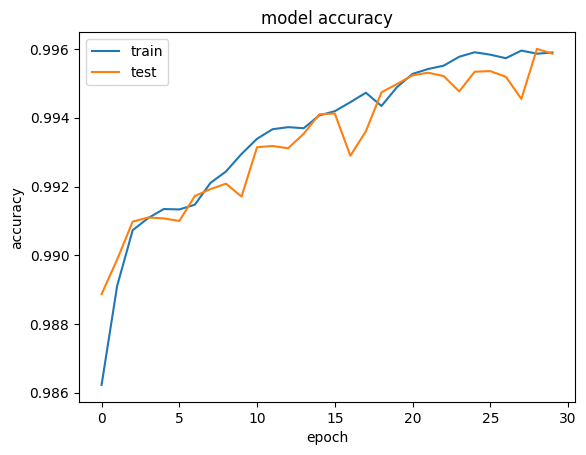

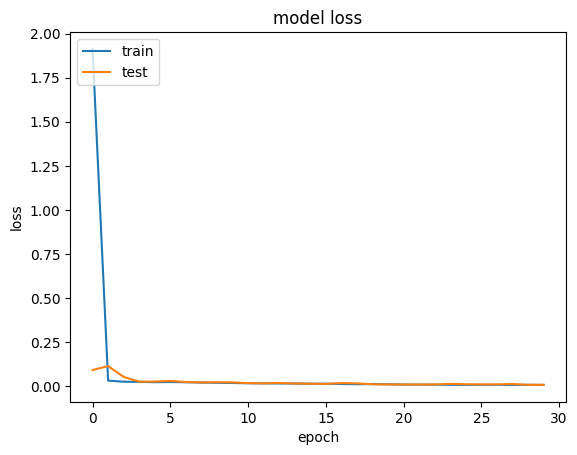

In [ ]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
result= model.evaluate(test_image, test_mask,verbose=0)

In [ ]:
len(test_image)

764

In [ ]:
print('Accuracy of model: {}'.format(result[1]))

Accuracy of model: 0.9958428144454956


#Testing the model

In [ ]:
def result_mask(result):
  pred_mask = tf.argmax(result, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  image=np.array(pred_mask)
  last_mask=np.squeeze(image)

  return last_mask

def segmented_image(mask, test_image):
  blue_mask= np.zeros(shape= (mask.shape[0], mask.shape[1], 3), dtype=np.int32)
  for i in range(test_image.shape[0]):
    for j in range(test_image.shape[1]):
      if mask[i][j].any()==1:
        blue_mask[i][j][2]=255
  segmented_image= cv2.addWeighted(np.array(test_image*255, dtype=np.int32), 0.5, blue_mask, 0.5, 0.0, dtype=cv2.CV_32F)
  return segmented_image

def visualize(result, test_mask, test_image):
  unet_mask= result_mask(result)
  segmented_image_unet= segmented_image(unet_mask, test_image)
  segmented_image_real= segmented_image(test_mask, test_image)
  plt.figure(figsize=(20,20))

  plt.subplot(1,5,1)
  plt.imshow(test_image)
  plt.title(' Brain MRI')

  plt.subplot(1,5,2)
  plt.imshow(segmented_image_unet.astype(np.uint8))
  plt.title('Predicted segmentation')

  plt.subplot(1, 5, 3)
  plt.imshow(segmented_image_real.astype(np.uint8))
  plt.title('Real segmentation')

  plt.subplot(1, 5, 4)
  plt.imshow(unet_mask)
  plt.title('Predicted mask')

  plt.subplot(1, 5, 5)
  plt.imshow(np.squeeze(test_mask))
  plt.title('Real mask')

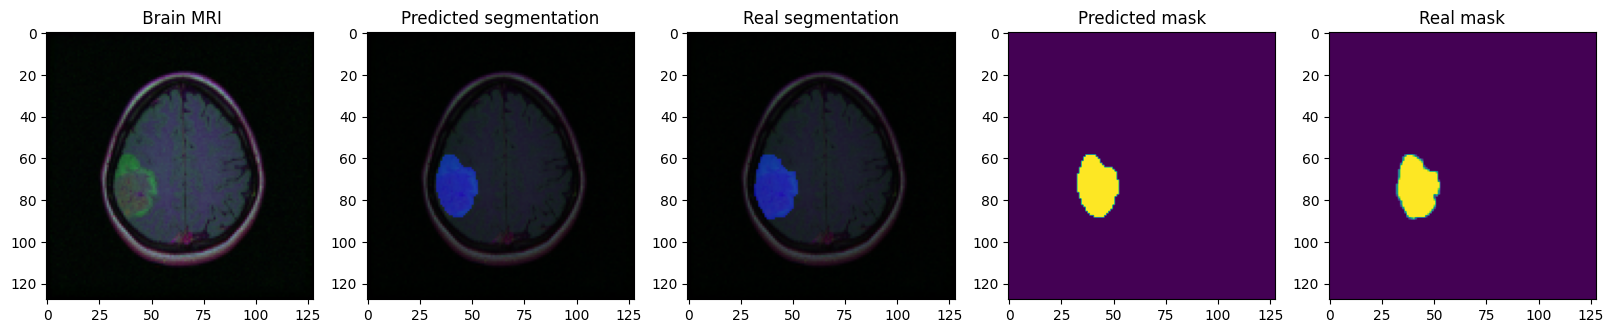

In [ ]:
visualize(results[64], test_mask[64], test_image[64])

In [ ]:
import json
import requests

SERVE_URL = "https://d73848bbc8a9e440786b4d5773ab3f6cd.clg07azjl.paperspacegradient.com/"


data = json.dumps({"signature_name": "serving_default", "instances": test_image[64].tolist()})
headers = {"content-type": "application/json"}
json_response = requests.post(SERVE_URL, data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

SSLError: ignored

In [ ]:
!curl https://d73848bbc8a9e440786b4d5773ab3f6cd.clg07azjl.paperspacegradient.com/healthcheck

Bad Gateway

In [ ]:
pip install -U gradient

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 11.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
print(test_image[64])

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00392157 0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00392157 0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.00784314 0.        ]
  ...
  [0.00392157 0.00784314 0.        ]
  [0.         0.00784314 0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.00784314 0.        ]
  ...
  [0.         0.01960784 0.        ]
  [0.         0.01176471 0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
